In [1]:
import h5py
import matplotlib.pyplot as plt
import os.path
import time
import numpy as np
import pandas as pd
from random import randint
import seaborn as sns

## Load the dataset 

In [2]:
path = 'usps.h5'
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [3]:
# no. of records in training and testing data
print('No. of samples in Train Dataset: ',len(X_tr))
print('No. of samples in Test Dataset: ',len(X_te))

No. of samples in Train Dataset:  7291
No. of samples in Test Dataset:  2007


In [4]:
#unique labels present in training data
print('Labels of training data: ', set(y_tr))

Labels of training data:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## Show some examples

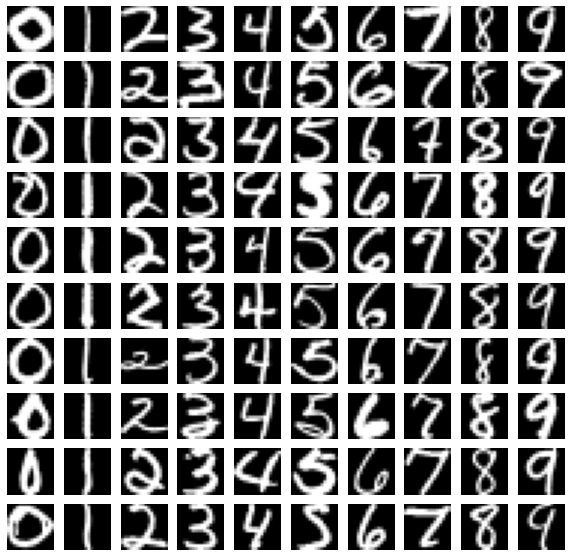

In [5]:
num_samples = 10
num_classes = len(set(y_tr))

classes = set(y_tr)
num_classes = len(classes)
fig, ax = plt.subplots(num_samples, num_classes, sharex = True, sharey = True, figsize=(num_classes, num_samples))

for label in range(num_classes):
    class_idxs = np.where(y_tr == label)
    for i, idx in enumerate(np.random.randint(0, class_idxs[0].shape[0], num_samples)):
        ax[i, label].imshow(X_tr[class_idxs[0][idx]].reshape([16, 16]), 'gray')
        ax[i, label].set_axis_off()

In [6]:
def get_binary_class_labels(y_true_noBinary:np.ndarray, class_num:int):
    
    '''
    Transform the labels from multi-class values to binary-class values.
    
    
    Parameters
    ------------------------
    y_true_noBinary:np.ndarray,
        Array that contains the multi-class labels.
    class_num:int,
        The value of the class that represents the positive class in the binary-class values.
    
    
    Returns
    ------------------------
    An array containing the binary classification for the specified class.
    '''
    
    n_samples  = y_true_noBinary.shape[0]
    y_true_binary = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if y_true_noBinary[i] == class_num:
            y_true_binary[i] = 1
        else:
            y_true_binary[i] = -1
    return y_true_binary

In [7]:
def gaussian_kernel(x:np.ndarray, y:np.ndarray, gamma:float=0.25):
    '''
    Compute the similarity value between x and y using the Gaussian Kernel
    
    
    Parameters
    ------------------------
    x:np.ndarray,
        The first argument to compute the similarity measure.
    y:np.ndarray,
        The second argument to compute the similarity measure.
    gamma:float=0.25,
        The value of the width of the Gaussian function. Default value=0.25
    
    
    Returns
    ------------------------
    The similarity measure between x and y.
    '''
    
    mean = np.linalg.norm(x - y)**2
    return np.exp(-mean/(2*gamma))

In [8]:
def get_train_accuracy(x:np.ndarray, y:np.ndarray, classifiers:list):
    '''
    Compute the training accuracy.
    
    
    Parameters
    ------------------------
    x:np.ndarray,
        The training data.
    y:np.ndarray,
        The label of the training data.
    classifiers:list,
        The classifiers already trained.
    
    
    Returns
    ------------------------
    The accuracy of the training data for the multiclass classification problem with zero-one loss.
    '''
    
    wrong_classifications = 0
    for i, sample in enumerate(x):
        prediction_multiclass = get_max_prediction(x, y, classifiers, sample)
        if prediction_multiclass != y[i]:
            wrong_classifications +=1
    train_accuracy = (len(y)-wrong_classifications)/len(y)
    return train_accuracy

In [9]:
def get_test_accuracy(x_tr:np.ndarray, y_tr:np.ndarray, x_test:np.ndarray, y_test:np.ndarray, classifiers:list):
    '''
    Compute the training accuracy.
    
    
    Parameters
    ------------------------
    x_tr:np.ndarray,
        The training data.
    y_tr:np.ndarray,
        The label of the training data.
    x_test:np.ndarray,
        The test data.
    y_test:np.ndarray,
        The label of the test data.
    classifiers:list,
        The classifiers already trained.
    
    
    Returns
    ------------------------
    The accuracy of the test data for the multiclass classification problem with zero-one loss.
    '''
    
    wrong_classifications = 0
    for i, sample in enumerate(x_test):
        prediction_multiclass = get_max_prediction(x_tr, y_tr, classifiers, sample)
        if prediction_multiclass != y_test[i]:
            wrong_classifications +=1
    test_accuracy = (len(y_test)-wrong_classifications)/len(y_test)
    return test_accuracy

In [10]:
def get_scores(x_tr:np.ndarray, y_tr:np.ndarray, x_test:np.ndarray, y_test:np.ndarray, classifiers:list):
    '''
    Compute the training and test accuracy.
    
    
    Parameters
    ------------------------
    x_tr:np.ndarray,
        The training data.
    y_tr:np.ndarray,
        The label of the training data.
    x_test:np.ndarray,
        The test data.
    y_test:np.ndarray,
        The label of the test data.
    classifiers:list,
        The classifiers already trained.
    
    
    Returns
    ------------------------
    The accuracy of the training and the test data for the multiclass classification problem with zero-one loss.
    '''
    
    train_accuracy = get_train_accuracy(x_tr, y_tr, classifiers)    
    test_accuracy = get_test_accuracy(x_tr, y_tr, x_test, y_test, classifiers)
    
    return train_accuracy, test_accuracy

In [11]:
def get_binary_label(S_i_y_j:np.ndarray, binary_class:int):
    '''
    Compute the binary label given the binary class.
    
    
    Parameters
    ------------------------
    S_i_y_j:np.ndarray,
        The label in the multi-class classification problem.
    binary_class:int,
        The class for which we want the binary label.
    
    
    Returns
    ------------------------
    The binary label for the specified class.
    '''
    
    if S_i_y_j == binary_class:
        binary_label_j = 1
    else:
        binary_label_j = -1
    return binary_label_j

In [12]:
def fit(x_tr:np.ndarray, y_tr:np.ndarray, lambda_param:float, T_param:int, list_labels:list):
    '''
    Compute the binary classifiers.
    
    
    Parameters
    ------------------------
    x_tr:np.ndarray,
        The training data.
    y_tr:np.ndarray,
        The label of the training data.
    lambda_param:float,
        The lambda regularizer parameter to use in the binary classifiers.
    T_param:int,
        The number of steps to use in the binary classifiers.
    list_labels:list,
        The unique list of the labels in the training set that defines the binary classifiers.
    
    
    Returns
    ------------------------
    The len(list_labels) binary classifiers trained with lambda_param e T_param.
    '''
        
    num_S = len(y_tr)
    alphas = []
    for f in range(10):
        alphas.append(dict())
    for t in range(1, T_param+1):
        it = randint(0, num_S-1)
        for i in list_labels:
            sum_ = 0
            alpha = alphas[i]
            for j in alpha:
                y_binary_j = get_binary_label(y_tr[j], i)
                similarity_measure = gaussian_kernel(x_tr[it], x_tr[j])
                product = alpha[j] * y_binary_j * similarity_measure
                sum_ += product
            y_binary_it = get_binary_label(y_tr[it], i)
            if y_binary_it * (1/(lambda_param*(t))) * sum_ < 1:
                if it in alpha:
                    alpha[it] += 1
                else:
                    alpha[it] = 1
            alphas[i] = alpha
    classifiers = []
    for alpha in alphas:
        classifier = {key: value * (1/(lambda_param*t)) for key, value in alpha.items()}
        classifiers.append(classifier)
    return classifiers

In [13]:
def fit_and_predict(x_tr:np.ndarray, y_tr:np.ndarray, x_te:np.ndarray, y_te:np.ndarray, lambda_param:float, T_param:int, list_labels:int):
    '''
    Compute the training and test accuracy of the multi-class classification problem.
    
    
    Parameters
    ------------------------
    x_tr:np.ndarray,
        The training data.
    y_tr:np.ndarray,
        The label of the training data.
    x_te:np.ndarray,
        The validation data.
    y_te:np.ndarray,
        The label of the validation data.
    lambda_param:float,
        The lambda regularizer parameter to use in the binary classifiers.
    T_param:int,
        The number of steps to use in the binary classifiers.
    list_labels:list,
        The unique list of the labels in the training set that defines the binary classifiers.
    
    
    Returns
    ------------------------
    The train and the test accuracy score.
    '''
    
    classifiers = fit(x_tr, y_tr, lambda_param, T_param, list_labels)
    train_accuracy, test_accuracy = get_scores(x_tr, y_tr, x_te, y_te, classifiers)
    return train_accuracy, test_accuracy

In [14]:
def predict_binary(alpha:dict, x_tr:np.ndarray, y_tr:np.ndarray, sample_test:np.ndarray, class_to_predict:int):
    '''
    Compute the binary prediction.
    
    
    Parameters
    ------------------------
    alpha:dict,
        Dictionary containing the values of the vector alpha.
    x_tr:np.ndarray,
        The training data.
    y_tr:np.ndarray,
        The label of the training data.
    sample_test:np.ndarray,
        The sample for which we want to compute the binary prediction.
    class_to_predict:int,
        The binary class to use for the binary prediction.
    
    
    Returns
    ------------------------
    The prediction made by the binary classifier on the sample.
    '''
    
    decision = 0.0
    for k in alpha.keys():
        y_tr_binary_k = get_binary_label(y_tr[k], class_to_predict)
        decision += alpha[k] * y_tr_binary_k * gaussian_kernel(x_tr[k], sample_test)
    return decision

In [15]:
def get_max_prediction(x_tr:np.ndarray, y_tr:np.ndarray, classifiers:list, sample:np.ndarray):
    '''
    Compute the multiclass prediction.
    
    
    Parameters
    ------------------------
    x_tr:np.ndarray,
        The training data.
    y_tr:np.ndarray,
        The label of the training data.
    classifiers:list,
        List containing the representation of the binary classifiers.
    sample_test:np.ndarray,
        The sample for which we want to compute the binary prediction.
    
    
    Returns
    ------------------------
    The prediction made by the multiclass classifier on the sample.
    '''   
    
    max_prediction = 0
    class_predicted = 0
    for i, classifier in enumerate(classifiers):
        prediction = predict_binary(classifier, x_tr, y_tr, sample, i)
        if i == 0:
            max_prediction = prediction
            class_predicted = i
        else:
            if prediction > max_prediction:
                max_prediction = prediction
                class_predicted = i
    return class_predicted

In [23]:
def K_fold_CV(X:np.ndarray, y:np.ndarray, k:int, lambda_params:np.ndarray, T_params:np.ndarray, list_unique_labels:list):
    '''
    timestr = time.strftime("%Y%m%d-%H%M%S")
    current_path = os.path.abspath("")
    new_folder = '/Results' + timestr
    os.mkdir(current_path + new_folder)
    '''
    
    ##check that X and y have the same number of samples
    if X.shape[0] != y.shape[0]:
        raise ValueError('The number of samples in the Data and the labels is different!')
        
    n_samples = X.shape[0]
    
    if k > n_samples:
        raise ValueError('The K parameter cannot be bigger than the number of samples!')
        
        
    n_samples_per_fold = int(n_samples/k)
    list_results = []
    for lambda_param in lambda_params:
        print('Lambda:', lambda_param)
        
        
        
        for T_param in T_params:
            T_param = int(T_param)
            print('T:', T_param)
            print(time.strftime("%Y%m%d-%H%M%S"))
            
            train_accuracy_mean = 0
            test_accuracy_mean = 0
            for n_fold, i in enumerate(range(0, n_samples, n_samples_per_fold)):
                start = i
                end = i + int(n_samples_per_fold)
                if end > n_samples:
                    break
                X_D_i = X[start:end]
                X_S_i = np.concatenate((X[end: ],X[:start]), axis=0) 
                y_D_i = y[start:end]
                y_S_i = np.concatenate((y[end: ],y[:start]), axis=0)

                train_accuracy, test_accuracy = fit_and_predict(X_S_i, y_S_i, X_D_i, y_D_i, lambda_param, T_param, list_unique_labels)
                train_accuracy_mean += train_accuracy
                test_accuracy_mean += test_accuracy
            train_accuracy_mean = train_accuracy_mean/k
            test_accuracy_mean = test_accuracy_mean/k
            params = dict({'lambda': lambda_param, 'T': T_param,
                              'TrainAccuracy': train_accuracy_mean,
                               'TestAccuracy': test_accuracy_mean
                                  })
            list_results.append(params)

    return list_results

In [17]:
def split(X:np.ndarray, y:np.ndarray, test_rate:float):
    '''
    Split the dataset in train and test dataset.
    
    
    
    Parameters
    ------------------------
    X:np.ndarray,
        All the data available.
    y:np.ndarray,
        The label of all the data available.
    test_rate:float,
        The rate of the Dataset that becomes the test dataset.
    
    
    Returns
    ------------------------
    The data and the label of the new two datasets.
    '''       
    
    split_index = int(X.shape[0]*(1-test_rate))
    X_tr, X_te = X[:split_index,:], X[split_index:,:]
    y_tr, y_te = y[:split_index,], y[split_index:,]
    return X_tr, y_tr, X_te, y_te

In [18]:
def get_best_params(list_params_performance:list):
    '''
    Get the lambda and the T values that determine the best value for test accuracy.
    
    
    
    Parameters
    ------------------------
    list_params_performance:list,
        List that contains a dictionary for every parameter pairs.
    
    
    Returns
    ------------------------
    The lambda and the T values that determine the best value for the k-fold CV test accuracy.
    '''
    
    best_test_accuracy = list_params_performance[0]['TestAccuracy']
    lambda_param_best = list_params_performance[0]['lambda']
    T_param_best = list_params_performance[0]['T']
    for dictionary in list_params_performance[1:]:
        test_accuracy = dictionary['TestAccuracy']
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            lambda_param_best = dictionary['lambda']
            T_param_best = dictionary['T']
    return lambda_param_best, T_param_best

In [19]:
def plot_one_fixed_variable(list_results:list, parameter_fix:str, parameter_variable:str):
    fig, axs = plt.subplots(ncols=len(list(set([x[parameter_fix] for x in list_results]))), figsize=(20, 5),sharey=True)
    for j, lambda_now in enumerate(sorted(list(set([x[parameter_fix] for x in list_results])))):
        list_p = []
        list_train_acc = []
        list_test_acc = []
        for di in list_results:
            if di[parameter_fix] == lambda_now:
                list_p.append(di[parameter_variable])
                list_train_acc.append(di['TrainAccuracy'])
                list_test_acc.append(di['TestAccuracy'])
        if parameter_fix == 'T':
            list_p = np.log10(list_p)
        axs[j].set_title('{} = {}'.format(parameter_fix, lambda_now))
        axs[j].plot(list_p, list_train_acc, label='Training accuracy')
        axs[j].plot(list_p, list_test_acc, label='Testing accuracy')
        axs[j].set_xlabel(parameter_variable)
        axs[j].set_ylabel('Accuracy')
        axs[j].legend()

In [29]:
def plot_heatmap(list_results:list):
    fig, axs = plt.subplots(1, figsize=(10, 10))
    dictionary_end_te = dict()
    for dictionary in list_results:
        key = str(dictionary['lambda']) + ';' + str(dictionary['T'])
        dictionary_end_te[key] = float(dictionary['TestAccuracy'])
    dict_dataframe = dict()
    list_index = []
    for key, value in dictionary_end_te.items():
        lambda_, T = key.split(';')
        if T not in list_index:
            list_index.append(T)
        if lambda_ in dict_dataframe.keys():
            dict_dataframe[lambda_].append(value)
        else:
            dict_dataframe[lambda_] = [value]
    hm = pd.DataFrame(data=dict_dataframe, index=list_index)
    axs = sns.heatmap(hm, annot=True, fmt='.5f')
    axs.set(xlabel='lambda', ylabel='T')

In [25]:
def test_accuracy_best_params(X:np.ndarray, y:np.ndarray, k:int, lambda_params:np.ndarray, T_params:np.ndarray, test_rate:float, shuffle:bool=True):
    '''
    Divide the Dataset in train and test. Use the train dataset to run a k-fold CV and 
    return the parameters that give the best value for accuracy.
    Retrain the model with the best parameters using the hole training dataset.
    Use the retrained model to compute the accuracy of the test dataset.
    
    
    
    Parameters
    ------------------------
    X:np.ndarray,
        All the data available.
    y:np.ndarray,
        The label of all the data available.
    k:int,
        The number of folds to be used in the k-fold cross validation.
    lambda_params:np.ndarray,
        The values of the lambda paramater to be tested.
    T_params:np.ndarray,
        The values of the T parameter to be tested.
    test_rate:float,
        The rate of the Dataset that becomes the test dataset.
    shuffle:bool=True,
        Whether to shuffle the data. Default value is True.
        
    
    
    Returns
    ------------------------
    The test accuracy with the best parameters found and 
    the list of all the parameters with their relative train and test accuracy
    '''   
    
    ##check that X and y have the same number of samples
    if X.shape[0] != y.shape[0]:
        raise ValueError('The number of samples in the Data and the labels is different!')
        
    n_samples = X.shape[0]
        
    #WHETHER TO SHUFFLE THE INDECES OF THE DATASET (BOTH THE EXAMPLES AND THE LABELS)
    if shuffle:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
        
    X_tr, y_tr, X_te, y_te = split(X, y, test_rate)
    list_unique_labels = list(set(y_tr))
    list_params_performance = K_fold_CV(X_tr, y_tr, k, lambda_params, T_params, list_unique_labels)
    lambda_param_best, T_param_best = get_best_params(list_params_performance)
    train_accuracy, test_accuracy = fit_and_predict(X_tr, y_tr, X_te, y_te, lambda_param_best, T_param_best, list_unique_labels)
    plot_one_fixed_variable(list_params_performance, 'lambda', 'T')
    plot_one_fixed_variable(list_params_performance, 'T', 'lambda')
    plot_heatmap(list_params_performance)
    return test_accuracy,lambda_param_best,T_param_best, list_params_performance

In [22]:
X_all = np.concatenate((X_tr, X_te), axis=0)
y_all = np.concatenate((y_tr, y_te), axis=0)

In [ ]:
test_accuracy_best_params(X_all, y_all, 5, np.logspace(-3, 3, 5), np.array([10,100,500,1000]), 0.2)

In [27]:
list_results = [{'lambda': 0.001,
   'T': 10,
   'TrainAccuracy': 0.43969080826751805,
   'TestAccuracy': 0.4477471418964358},
  {'lambda': 0.001,
   'T': 100,
   'TrainAccuracy': 0.7893463283481769,
   'TestAccuracy': 0.7810356422326833},
  {'lambda': 0.001,
   'T': 500,
   'TrainAccuracy': 0.903377583599395,
   'TestAccuracy': 0.8907868190988568},
  {'lambda': 0.001,
   'T': 1000,
   'TrainAccuracy': 0.933456561922366,
   'TestAccuracy': 0.9218560860793543},
  {'lambda': 0.03162277660168379,
   'T': 10,
   'TrainAccuracy': 0.440799865568812,
   'TestAccuracy': 0.4477471418964358},
  {'lambda': 0.03162277660168379,
   'T': 100,
   'TrainAccuracy': 0.7845740211729122,
   'TestAccuracy': 0.7825151311365165},
  {'lambda': 0.03162277660168379,
   'T': 500,
   'TrainAccuracy': 0.9025373886741723,
   'TestAccuracy': 0.9000672494956288},
  {'lambda': 0.03162277660168379,
   'T': 1000,
   'TrainAccuracy': 0.9331876995462949,
   'TestAccuracy': 0.9183591123066577},
  {'lambda': 1.0,
   'T': 10,
   'TrainAccuracy': 0.45545286506469507,
   'TestAccuracy': 0.44263618022864826},
  {'lambda': 1.0,
   'T': 100,
   'TrainAccuracy': 0.7797344984036296,
   'TestAccuracy': 0.7757901815736382},
  {'lambda': 1.0,
   'T': 500,
   'TrainAccuracy': 0.9021340951100655,
   'TestAccuracy': 0.8948217888365837},
  {'lambda': 1.0,
   'T': 1000,
   'TrainAccuracy': 0.9345992270206687,
   'TestAccuracy': 0.9198386012104909},
  {'lambda': 31.622776601683793,
   'T': 10,
   'TrainAccuracy': 0.4257099647118131,
   'TestAccuracy': 0.42030934767989236},
  {'lambda': 31.622776601683793,
   'T': 100,
   'TrainAccuracy': 0.7990589816837506,
   'TestAccuracy': 0.8},
  {'lambda': 31.622776601683793,
   'T': 500,
   'TrainAccuracy': 0.900924214417745,
   'TestAccuracy': 0.8930733019502354},
  {'lambda': 31.622776601683793,
   'T': 1000,
   'TrainAccuracy': 0.9325155436061167,
   'TestAccuracy': 0.9218560860793545},
  {'lambda': 1000.0,
   'T': 10,
   'TrainAccuracy': 0.42342463451520757,
   'TestAccuracy': 0.4337592468056489},
  {'lambda': 1000.0,
   'T': 100,
   'TrainAccuracy': 0.7825239455553687,
   'TestAccuracy': 0.775521183591123},
  {'lambda': 1000.0,
   'T': 500,
   'TrainAccuracy': 0.9050915812468492,
   'TestAccuracy': 0.9016812373907197},
  {'lambda': 1000.0,
   'T': 1000,
   'TrainAccuracy': 0.9355402453369182,
   'TestAccuracy': 0.9201075991930061}]

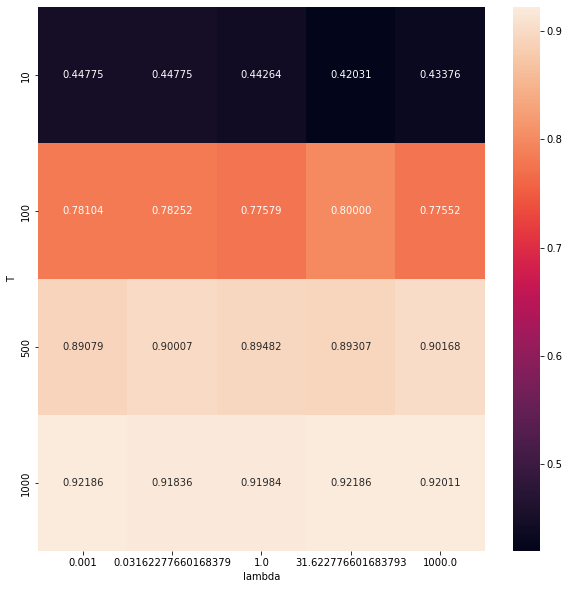

In [30]:
plot_heatmap(list_results)